In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from functools import reduce
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from skimage.feature import hog
from lesson_functions import *
%matplotlib inline

In [23]:
# import the python debugger
import pdb

### Read in dataset

In [24]:
# Read in cars and notcars
use_small = False

if use_small:
    image_files = glob.glob('./training_data/smallset/*/*.jpeg')
    car_files = []
    notcar_files = []
    for fname in image_files:
        if 'image' in fname or 'extra' in fname:
            notcar_files.append(fname)
        else:
            car_files.append(fname)

    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time
    sample_size = -1
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]
else:
    car_files = glob.glob('./training_data/fullset/vehicles/*/*.png')
    notcar_files = glob.glob('./training_data/fullset/non-vehicles/*/*.png')
    
    sample_size = -1
    car_files = car_files[0:sample_size]
    notcar_files = notcar_files[0:sample_size]

In [27]:
import random

In [74]:
icar = random.randint(0,len(car_files))
inocar = random.randint(0,len(notcar_files))

In [81]:
print(str(icar))

6459


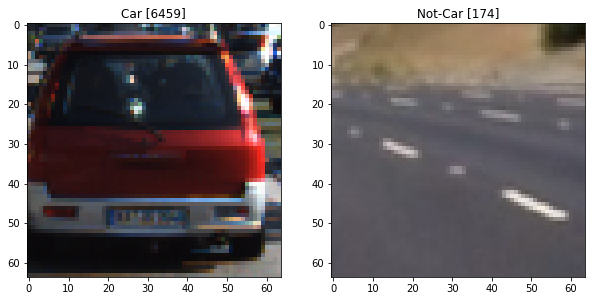

In [85]:
car_img = mpimg.imread(car_files[icar])
nocar_img = mpimg.imread(notcar_files[inocar])

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car ['+str(icar)+']')
plt.subplot(122)
plt.imshow(nocar_img)
plt.title('Not-Car ['+str(inocar)+']')
plt.show()

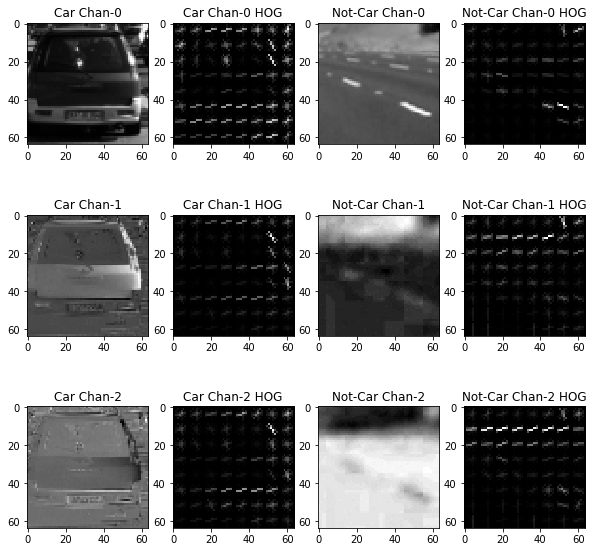

In [97]:
car_img_colored = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
nocar_img_colored = cv2.cvtColor(nocar_img, cv2.COLOR_RGB2YCrCb)

orient = 9
pix_per_cell = 8
cell_per_block = 2

fig = plt.figure(figsize=(10,10))

for ch in range(3):

    carimg = car_img_colored[:,:,ch]
    nocarimg = nocar_img_colored[:,:,ch]

    car_feat, car_hogimg = get_hog_features(carimg, orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=False)

    nocar_feat, nocar_hogimg = get_hog_features(nocarimg, orient, pix_per_cell, cell_per_block,
                                                vis=True, feature_vec=False)

    plt.subplot(3,4,4*ch+1)
    plt.imshow(carimg, cmap='gray')
    plt.title('Car Chan-'+str(ch))

    plt.subplot(3,4,4*ch+2)
    plt.imshow(car_hogimg, cmap='gray')
    plt.title('Car Chan-'+str(ch)+' HOG')
    
    plt.subplot(3,4,4*ch+3)
    plt.imshow(nocarimg, cmap='gray')
    plt.title('Not-Car Chan-'+str(ch))
    
    plt.subplot(3,4,4*ch+4)
    plt.imshow(nocar_hogimg, cmap='gray')
    plt.title('Not-Car Chan-'+str(ch)+' HOG')

plt.show()


In [68]:
car_feat.shape

(7, 7, 2, 2, 9)

### Set parameters and train model

In [2]:
#---------------------
# Training parameters
#---------------------

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

# spatial binning dimensions
spatial = (32,32) # 32 seems optimal

# histogram binsdd
histbin = 32 # 32 seems pretty good

# HOG parameters
orient = 9 #9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [ ]:
#--------------------
# Feature extraction
#--------------------

t=time.time()
car_features = extract_features(car_files, color_space=colorspace,
                                spatial_size=spatial, hist_bins=histbin,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcar_files, color_space=colorspace,
                                   spatial_size=spatial, hist_bins=histbin,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print()

#------------------
# Setup X & y data
#------------------

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#------------------
# Train/Test split
#------------------

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Parameters:')
print(colorspace,'color spaces')
print(spatial[0],'spatial params,', histbin, 'histogram bins')
print('HOG: channels = ',hog_channel)
print(orient,'orientations',pix_per_cell,'pixels per cell and',
      cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print()

# Use a linear SVC 
svc = LinearSVC()

#-------------
# Train model
#-------------

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
# save off model into pickle file
pickle_jar = {'svc': svc,
              'X_scaler': X_scaler,
              'orient': orient,
              'pix_per_cell': pix_per_cell,
              'cell_per_block': cell_per_block,
              'spatial': spatial,
              'histbin': histbin}
with open('saved_model.p', 'wb') as f:
    pickle.dump(pickle_jar, f)

## If model saved, then just run here to load it

In [3]:
# alternately, load saved model
pickle_jar = pickle.load( open('saved_model_0.p', 'rb'))

svc = pickle_jar['svc']
X_scaler = pickle_jar['X_scaler']
orient = pickle_jar['orient']
pix_per_cell = pickle_jar['pix_per_cell']
cell_per_block = pickle_jar['cell_per_block']
spatial = pickle_jar['spatial']
histbin = pickle_jar['histbin']

### Predict on images
Now that we have:
- X_scaler
- svc

Let's run it on some images...

In [4]:
from scipy.ndimage.measurements import label

In [5]:
# img = mpimg.imread('./test_images/straight_lines2.jpg')
img = mpimg.imread('./test_images/test4.jpg')

From experimentation, looks like bounding box scaling at **[0.75, 1.0, 1.5, 2.0]** are sufficient. Maybe even drop the 0.75, as possible diminishing return.

11 bounding boxes found, out of 912 searches at 1.0 scale level


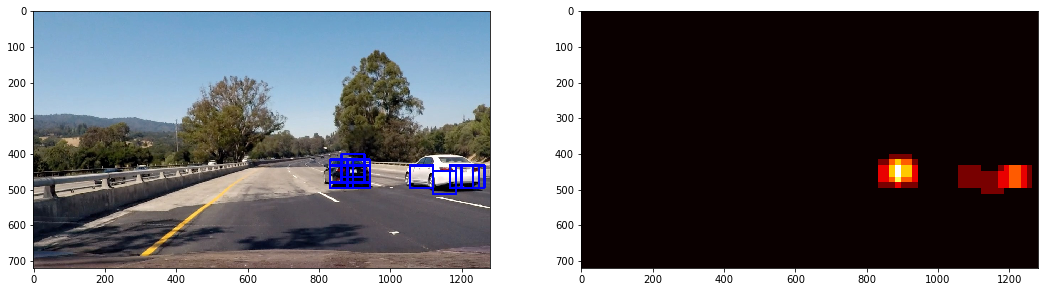

In [8]:
ystart = 400
ystop = 656
scale = 1.0

bbox_list, out_img, n = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial, histbin)

# create heatmap for this frame
threshold = 0
heatmap = np.clip(make_heatmap(img.shape[:2], bbox_list, threshold), 0, 127)

# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(img, labels)

plt.figure(figsize=(18,32*2))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

print(len(bbox_list),'bounding boxes found, out of',n,'searches at',scale,'scale level')

5 bounding boxes found, out of 144 searches at 2.0 scale level


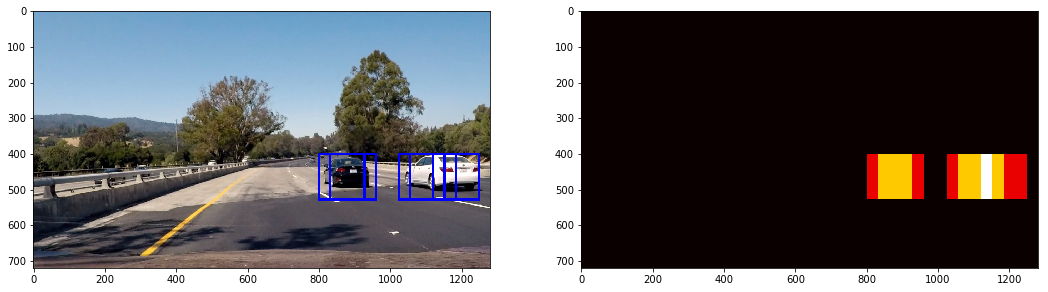

In [9]:
ystart = 400
ystop = 656
scale = 2.0

bbox_list, out_img, n = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                               orient, pix_per_cell, cell_per_block, spatial, histbin)

# create heatmap for this frame
threshold = 0
heatmap = np.clip(make_heatmap(img.shape[:2], bbox_list, threshold), 0, 127)

# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(img, labels)

plt.figure(figsize=(18,32*2))
plt.subplot(121)
plt.imshow(out_img)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')

print(len(bbox_list),'bounding boxes found, out of',n,'searches at',scale,'scale level')

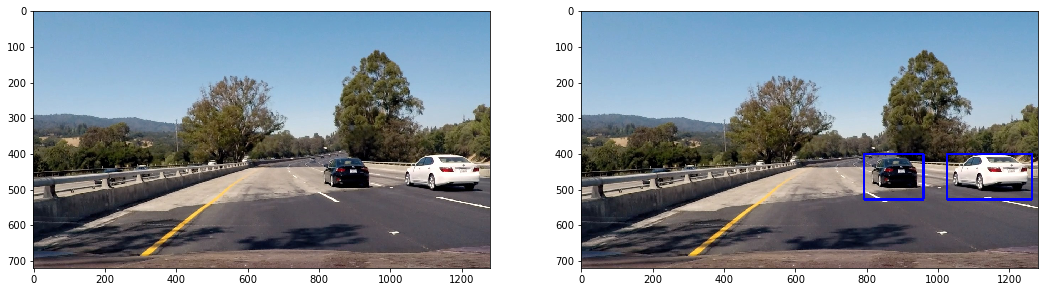

In [92]:
# heatmap_history.clear()
test_img = find_vehicles(img)

plt.figure(figsize=(18,32*2))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(test_img)

# Process on video images

### Setup a [circular buffer](https://en.wikipedia.org/wiki/Circular_buffer) to save past x-frames of heat map images

In [10]:
import collections

In [11]:
save_frames = 10
heatmap_history = collections.deque(maxlen=save_frames)

### setup pipeline function

In [21]:
def find_vehicles(img):
    scales = [1.0, 2.0]
#     scales = [0.75, 1.0, 1.5, 2.0]
    heatmap = np.zeros(img.shape[:2]).astype(np.int8)
    threshold_static = 1
    threshold_dynamic = 1
    decay_rate = 2

    # loop thru all the search window sizes
    for scale in scales:
        bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell,
                              cell_per_block, spatial, histbin, include_img=False)
        heatmap = add_heat(heatmap, bbox_list)

    heatmap = apply_threshold(heatmap, threshold_static)
    heatmap = np.clip(heatmap, 0, 127)

    # add heatmap into circular buffer
    heatmap_history.append(heatmap)

#     heatmap_total = np.sum(heatmap_history, axis=0)

    # cool off the heatmap by decay_rate
    f = lambda a,b: a + np.clip((b-decay_rate),0,127)
    heatmap_total = reduce(f, heatmap_history)

    heatmap_total = apply_threshold(heatmap_total, threshold_dynamic)

    labels = label(heatmap_total)
    draw_img = draw_labeled_bboxes(img, labels)

    return draw_img

In [177]:
a = np.arange(9).reshape(1,3,3)
a_hist = np.repeat(a, 5, axis=0)

In [178]:
a_hist

array([[[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]],

       [[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]],

       [[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]],

       [[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]],

       [[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]])

In [191]:
f = lambda a,b: a + np.clip((b-2),0,127)
a_total = reduce(f, a_hist)

In [190]:
a_total

array([[ 0,  1,  6],
       [11, 16, 21],
       [26, 31, 36]])

In [192]:
a_total

array([[ 0,  1,  2],
       [ 7, 12, 17],
       [22, 27, 32]])

In [187]:
np.clip(a_hist[1]-3, 0, 127)

array([[0, 0, 0],
       [0, 1, 2],
       [3, 4, 5]])

In [188]:
a_hist[0] - np.clip(a_hist[1]-3, 0, 127)

array([[0, 1, 2],
       [3, 3, 3],
       [3, 3, 3]])

In [168]:
f = lambda a,b: a + np.clip((b-1),0,127)
heatmap_total = reduce(f, heatmap_history)

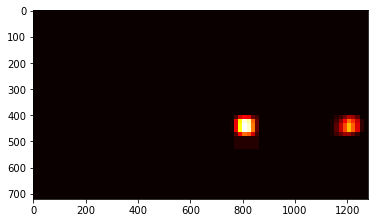

In [169]:
plt.imshow(heatmap_total, cmap='hot')

## import video editing modules

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [14]:
from moviepy import __version__
print(__version__)

0.2.2.13


In [15]:
vid_input = 'project_video.mp4'
# vid_input = 'test_video.mp4'

vid_output = 'my_project_video.mp4'

clip1 = VideoFileClip(vid_input)

In [22]:
heatmap_history.clear()
vid1_clip = clip1.fl_image(find_vehicles) #NOTE: this function expects color images!!
%time vid1_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video my_project_video.mp4
[MoviePy] Writing video my_project_video.mp4


100%|█████████▉| 1260/1261 [32:24<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_project_video.mp4 

CPU times: user 31min 27s, sys: 48.4 s, total: 32min 16s
Wall time: 32min 25s
